In [1]:
import pickle
import sys
from collections import defaultdict
from pathlib import Path

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import parc
import scipy.cluster.hierarchy as sch
import seaborn as sns
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from skimage import measure, exposure
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import List
import skimage
from matplotlib.patches import Circle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import utils as utils
from config import *

# Read data

In [5]:
pixel_features = data_meta / "pixel_intensity.csv"  # location of file
df = pd.read_csv(pixel_features)

In [6]:
df = df.iloc[:,-4:]
df.head()

,Location,X,Y,Id
0,10,18,1086,6
1,10,19,1086,6
2,10,19,1087,6
3,10,19,1088,6
4,10,20,1085,6


In [7]:
# with open(data_meta / f"clustering_0.3.pickle", "rb") as f:
#     parc_labels, embeddings, pixels_bright = pickle.load(f)

In [8]:
with open(data_meta / f"kmeans_labels3.pickle", "rb") as f:
    c_labels, pixels_bright_o = pickle.load(f)

# Viz

## Cluster visualization of markers expression

In [9]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(pixels_bright_o)
pixels_bright_position = pd.DataFrame(x_scaled, columns=pixels_bright_o.columns, index=pixels_bright_o.index)

del x_scaled
del pixels_bright_o

In [10]:
pixels_bright_position["label"] = c_labels

del c_labels

# Get dataframe per cluster
df_per_label = pixels_bright_position.groupby("label").mean()
df_per_label.head()

,p-EGFR,APC,DKK1,Non-p-B-catenin,Cyclin E,EMMPRIN,Wnt1,RNF 43,p-AKT,p-B-catenin,...,mTOR,p-mTOR,AXIN1,DKK2,EGFR,B-tubin,Cyclin D1,H3k27me3-488,H3k4me3-647,H3k9Ac-555
label,,,,,,,,,,,,,,,,,,,,,
0,-0.723271,-0.399383,-0.574036,-0.512809,-0.443107,-0.458998,-0.542560,-0.369538,-0.499031,-0.102666,...,-0.365117,0.083145,-0.075983,-0.277650,-0.198928,-0.065247,-0.176384,-0.761077,-0.555836,-0.513908
1,1.714308,-0.086265,0.390551,0.951237,-0.025869,-0.221292,-0.385489,-0.294705,0.078697,-0.098521,...,-0.277278,-0.311725,-0.135001,0.081583,-0.033544,-0.136967,0.290240,0.654955,0.904900,0.879191
2,-0.749362,-0.451875,-0.594285,-0.886593,-0.529222,-0.513859,-0.458622,-0.392667,-0.650897,-0.421854,...,-0.445872,-0.481212,-0.449243,-0.753616,1.218023,-0.321522,-0.545569,-0.747198,-0.557753,-0.652747
3,-0.300734,-0.003233,-0.192062,-0.544931,-0.134298,-0.050948,0.186389,-0.072658,3.349487,-0.246982,...,-0.139048,-0.298586,-0.326889,-0.565673,-0.304588,-0.217845,-0.420173,-0.559144,-0.551606,-0.592167
4,-0.294580,-0.127561,-0.075153,-0.261949,-0.219255,-0.084797,-0.052155,-0.019129,-0.265925,-0.054661,...,-0.055168,0.012272,-0.026881,-0.250285,1.309412,-0.004509,-0.147112,-0.606763,-0.511966,-0.438317


In [11]:
my_cmap = "bwr"
scale_name = "Z-score"

log_norm = LogNorm(vmin=np.min(df_per_label.values), vmax=np.max(df_per_label.values))

In [12]:
def create_HM(
    df_per_label, my_cmap, row_colors, scale_name, cellSizePixels=20, **kwargs
):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams["figure.dpi"]
    marginWidth = (
        matplotlib.rcParams["figure.subplot.right"]
        - matplotlib.rcParams["figure.subplot.left"]
    )
    marginHeight = (
        matplotlib.rcParams["figure.subplot.top"]
        - matplotlib.rcParams["figure.subplot.bottom"]
    )
    Ny, Nx = df_per_label.shape
    figWidth = (Nx * cellSizePixels / dpi) / marginWidth
    figHeigh = (Ny * cellSizePixels / dpi) / marginHeight

    ax = sns.clustermap(
        df_per_label,
        cbar_kws={"fraction": 0.01},
        cmap=my_cmap,
        linewidth=0.1,
        col_cluster=False,
        row_colors=[row_colors],
        dendrogram_ratio=(0.1, 0.0),
        figsize=(figWidth, figHeigh),
        **kwargs,
    )
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xticklabels(
        ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
    )
    ax.ax_heatmap.set_xlabel("Marker")
    ax.ax_heatmap.set_ylabel("Cluster")

    # calculate the size of the heatmap axes
    axWidth = (Nx * cellSizePixels) / (figWidth * dpi)
    axHeight = (Ny * cellSizePixels) / (figHeigh * dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position(
        [ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, axWidth, axHeight]
    )

    # resize dendrograms to match
    ax_row_orig_pos = ax.ax_row_dendrogram.get_position()
    ax.ax_row_dendrogram.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    ax_row_orig_pos = ax.ax_row_colors.get_position()
    ax.ax_row_colors.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    
    pos = ax.ax_heatmap.get_position()
    cbar_size=0.2
    ax.ax_cbar.set_position((1.05, pos.y0, .03, cbar_size))

    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)


def create_umap(embeddings, labels, cmap, name = 'Umap'):
    fig, ax = plt.subplots(figsize=(10, 10))
    X, Y = embeddings[:, 0], embeddings[:, 1]
    ax.scatter(X, Y, c=labels, s=2, cmap=matplotlib.colors.ListedColormap(cmap))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Add arrow with spine
    pos = ax.get_position()
    ax.plot(pos.x1, pos.y0, ">k", transform=fig.transFigure, clip_on=False)
    ax.plot(pos.x0, pos.y1, "^k", transform=fig.transFigure, clip_on=False)

    # Add label
    ax.set_xlabel(f'{name} 1')
    ax.set_ylabel(f'{name} 2')

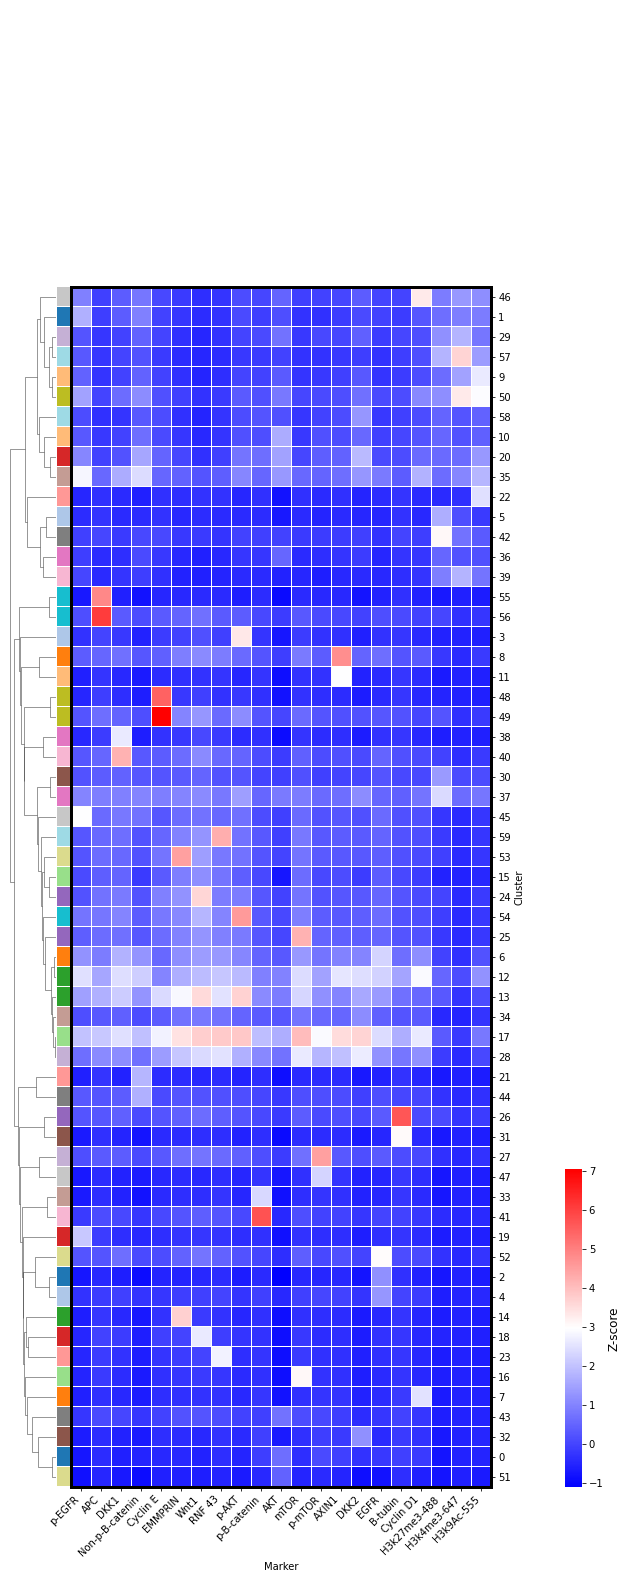

In [13]:
# Get linkage
d = sch.distance.pdist(df_per_label, metric='cosine')
L = sch.linkage(d, method="average")

# Get colormap
vals = np.linspace(0, 1, len(df_per_label))
my_cmap_row = plt.cm.tab20(vals)

# Clustermap and umap
labels = df_per_label.index.to_list()
my_cmap_dict = dict(zip(labels, my_cmap_row))
row_colors = pd.DataFrame(labels)[0].map(my_cmap_dict)
create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)
# create_umap(embeddings, parc_labels, my_cmap_row)

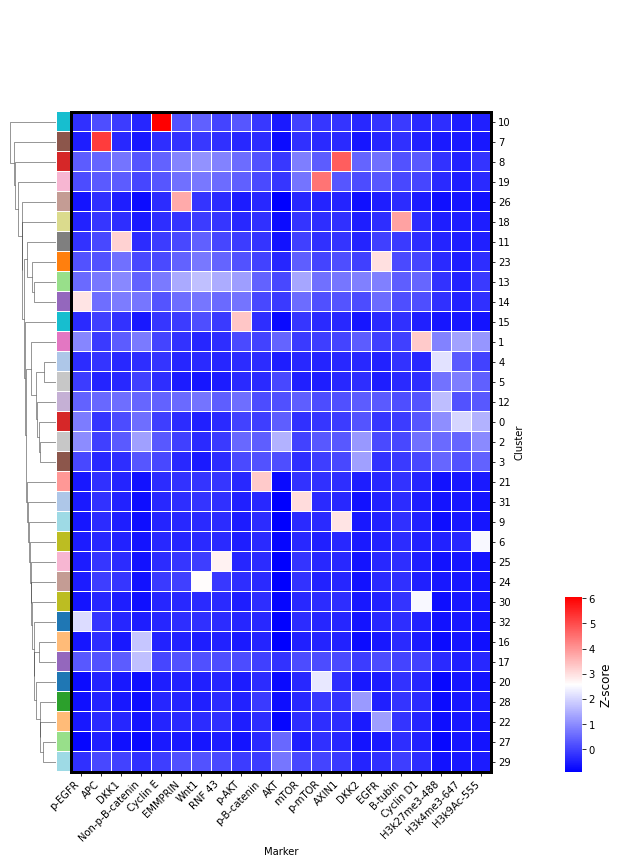

In [14]:
tol = 0.20

# Merge similar cluster
clusters = sch.fcluster(L, tol * d.max(), "distance") - 1
clusters_unique = np.unique(clusters)
n_clusters = len(np.unique(clusters))

# Clustermap and umap
label2cluster = dict(zip(labels, clusters))
result = defaultdict(int)
for k, v in zip(clusters, labels):
    result[k] = max(result[k], v)
row_colors = pd.DataFrame(labels)[0].map(label2cluster).map(result).map(my_cmap_dict)
clusters = np.array(list(map(label2cluster.get, labels)))
new_parc_labels = np.array(list(map(result.get, clusters)))
# create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)

# Clustermap and umap with new colormap
vals = np.linspace(0, 1, n_clusters)
np.random.seed(0)
np.random.shuffle(vals)
my_cmap_row = plt.cm.tab20(vals)
my_cmap_dict = dict(zip(clusters_unique, my_cmap_row))
row_colors = pd.DataFrame(labels)[0].map(label2cluster).map(my_cmap_dict)
new_parc_labels = np.array(list(map(label2cluster.get, labels)))
# create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)

# Combined 
df_combined = pixels_bright_position.copy()
df_combined.label = df_combined.label.map(label2cluster.get)
df_combined = df_combined.groupby("label").mean()
labels = df_combined.index.to_list()

row_colors = pd.DataFrame(labels)[0].map(my_cmap_dict)

create_HM(df_combined, my_cmap, row_colors, scale_name)


## Pixel location visualization

First we add back the location and condition information in the pixel_bright dataframe

In [15]:
pixels_bright_position = pixels_bright_position.join(df[["Location", "X", "Y", "Id"]])
pixels_bright_position

,p-EGFR,APC,DKK1,Non-p-B-catenin,Cyclin E,EMMPRIN,Wnt1,RNF 43,p-AKT,p-B-catenin,...,B-tubin,Cyclin D1,H3k27me3-488,H3k4me3-647,H3k9Ac-555,label,Location,X,Y,Id
7,-1.151059,5.015758,-1.146029,-1.573989,-0.934763,-1.055999,-0.820034,-0.825564,-1.157915,-0.469682,...,-0.829061,-1.263095,-0.829722,-0.651178,-1.097623,55,10,20,1088,6
76,-0.964738,-0.840422,-0.616521,-0.688960,-0.300800,-0.902696,-0.820034,-0.300585,-0.026004,1.941772,...,-0.908463,-0.572753,-0.829722,-0.642819,-0.374527,33,10,26,1093,6
83,2.515250,0.004000,-0.729944,-0.750247,-0.393122,-1.055999,-0.726904,-0.366194,-0.153933,-0.889311,...,-0.463685,-1.506083,-0.829722,-0.477105,-1.198203,19,10,26,1100,6
101,2.011051,0.232543,-1.231070,-0.914181,-0.934763,-1.055999,-0.520139,-0.338106,0.878057,-1.507395,...,-0.479565,-1.152705,-0.829722,-0.707318,-1.256145,19,10,27,1100,6
102,4.600505,-0.599332,-0.881275,-1.024798,-0.934763,-1.055999,-0.732736,-0.422476,2.286054,-0.347547,...,-1.504296,-1.506083,-0.829722,-0.513657,-1.066739,19,10,27,1101,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75824594,-1.151059,-0.840422,-1.226813,-0.701714,-0.934763,-0.658950,-0.820034,-1.006069,-1.157915,-1.563128,...,-1.005016,-1.421868,-0.662462,-0.707318,-0.258004,2,9,1380,1401,49
75824613,-1.151059,-0.840422,-0.795727,-1.573989,-0.899427,-1.055999,-0.622018,-1.006069,-1.157915,-1.614216,...,-1.504296,-1.506083,-0.829722,-0.452928,-1.256145,2,9,1380,1420,49
75824663,-1.151059,-0.840422,-1.002705,-1.573989,-0.934763,-1.055999,1.763927,-0.238262,-1.157915,-1.614216,...,-1.504296,-1.506083,-0.826641,-0.580123,-0.676994,2,9,1381,1414,49
75824664,-1.151059,-0.840422,-1.032809,-1.573989,-0.934763,-1.055999,2.831100,-0.078213,-1.120236,-1.071447,...,-1.136760,-1.506083,-0.783285,-0.707318,-0.960420,18,9,1381,1415,49


In [16]:
df_subset = pixels_bright_position[['label', 'Location', 'Id']]
df_subset.label =  df_subset.label.map(label2cluster.get)

C:\Users\thu71\.conda\envs\spatial_signaling\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [29]:
df_count = df_subset.groupby(['Location', 'Id', 'label']).size().unstack(fill_value=0)
df_count = df_count.div(df_count.sum(axis=1), axis=0)

In [30]:
df_count

label              0         1         2         3         4         5   \
Location Id                                                               
1        6   0.081368  0.000419  0.308723  0.032519  0.002512  0.001954   
         7   0.077496  0.000000  0.229016  0.128871  0.021852  0.003256   
         8   0.028802  0.000137  0.363344  0.045769  0.001026  0.000753   
         9   0.334444  0.000151  0.128294  0.088307  0.110421  0.016359   
         10  0.200925  0.000503  0.154186  0.023319  0.048749  0.007036   
...               ...       ...       ...       ...       ...       ...   
63       45  0.025556  0.000000  0.015484  0.122520  0.021046  0.240980   
         46  0.010354  0.000000  0.005665  0.087712  0.062219  0.199453   
         47  0.256126  0.000606  0.135596  0.084077  0.010304  0.054810   
         48  0.006864  0.003432  0.000468  0.020749  0.109204  0.232137   
         51  0.007179  0.000000  0.000769  0.014872  0.092564  0.271795   

label              6         7         8         9   ...        23        24  \
Location Id                                          ...                       
1        6   0.000419  0.036985  0.013398  0.021633  ...  0.002094  0.009630   
         7   0.002026  0.018958  0.006729  0.024385  ...  0.003473  0.024747   
         8   0.000205  0.011493  0.009783  0.006841  ...  0.015325  0.007525   
         9   0.000000  0.010451  0.001363  0.018176  ...  0.000151  0.009997   
         10  0.002714  0.040004  0.003920  0.028043  ...  0.007438  0.014976   
...               ...       ...       ...       ...  ...       ...       ...   
63       45  0.058779  0.018040  0.000000  0.013680  ...  0.006615  0.013530   
         46  0.037312  0.015726  0.000000  0.019340  ...  0.000098  0.003028   
         47  0.009438  0.017924  0.003810  0.012122  ...  0.003723  0.007360   
         48  0.051638  0.021529  0.002964  0.031357  ...  0.006084  0.005304   
         51  0.045385  0.027949  0.001282  0.017949  ...  0.002564  0.022564   

label              25        26        27        28        29        30  \
Location Id                                                               
1        6   0.012003  0.014794  0.029449  0.010328  0.009630  0.004187   
         7   0.017511  0.013242  0.043777  0.031548  0.005065  0.004631   
         8   0.013204  0.010194  0.018677  0.018540  0.010057  0.002942   
         9   0.008179  0.010300  0.016965  0.017419  0.002878  0.003938   
         10  0.018193  0.018595  0.045733  0.032566  0.016183  0.003518   
...               ...       ...       ...       ...       ...       ...   
63       45  0.017138  0.007517  0.085989  0.016085  0.004510  0.006314   
         46  0.002930  0.003712  0.214593  0.050791  0.000488  0.000195   
         47  0.005801  0.005282  0.102260  0.018097  0.004070  0.001212   
         48  0.035257  0.028081  0.031669  0.018253  0.011856  0.004212   
         51  0.040256  0.041538  0.049487  0.032564  0.009231  0.001795   

label              31        32  
Location Id                      
1        6   0.009491  0.004187  
         7   0.017221  0.006729  
         8   0.006157  0.004857  
         9   0.009391  0.005453  
         10  0.011860  0.031762  
...               ...       ...  
63       45  0.006915  0.009321  
         46  0.002735  0.000195  
         47  0.009005  0.004762  
         48  0.026209  0.007956  
         51  0.018462  0.004103  

[2437 rows x 33 columns]

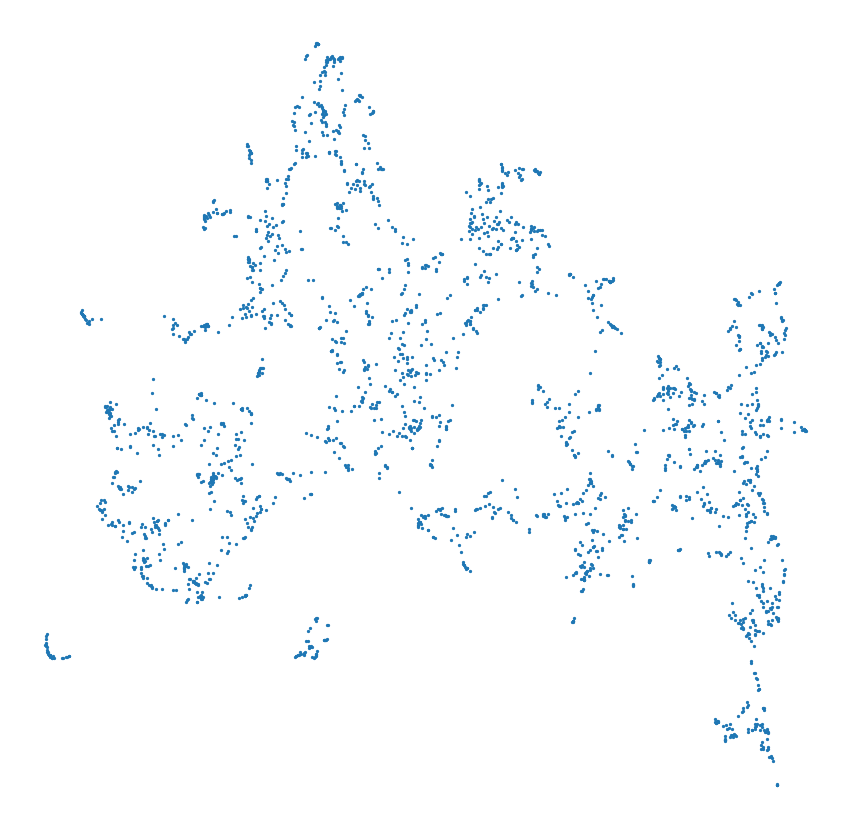

In [44]:
import umap

embeddings = umap.UMAP(n_neighbors=5, min_dist=0).fit_transform(df_count.values)
    
fig, ax = plt.subplots(figsize=(15, 15))
X, Y = embeddings[:, 0], embeddings[:, 1]
ax.scatter(X, Y, s=5)
ax.axis("off")
plt.show()

In [45]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 10
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(embeddings)
labels_2D = clustering.labels_

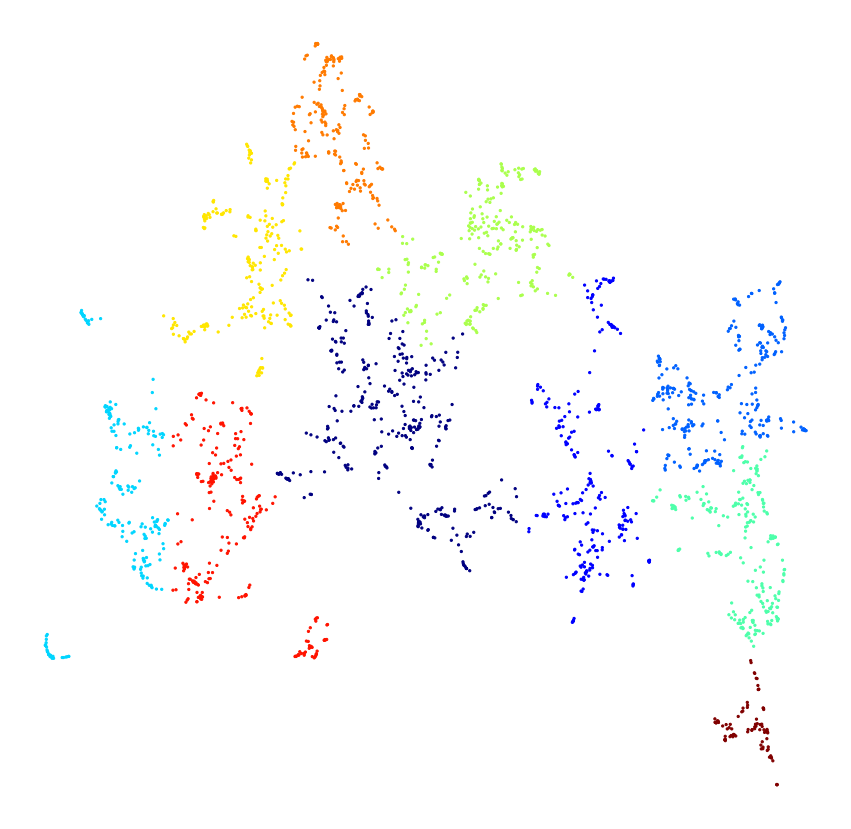

In [46]:
fig, ax = plt.subplots(figsize=(15, 15))
X, Y = embeddings[:, 0], embeddings[:, 1]
ax.scatter(X, Y, s=5, c=labels_2D, cmap='jet')
ax.axis("off")
plt.show()

In [47]:
import chart_studio
chart_studio.tools.set_credentials_file(username='thomashu96', api_key='3ibORctBES8H2sJDg74M')

In [56]:
import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as py


fig = go.Figure(data=go.Scatter(x=embeddings[:, 0],
                                y=embeddings[:, 1],
                                mode='markers',
                                marker=dict(
                                    size=5,
                                    color=labels_2D, #set color equal to a variable
                                    colorscale='Jet', # one of plotly colorscales
                                    showscale=False
                                ),
                                text=df_count.index.tolist())) # hover text goes here
fig.update_layout(width=800, height=800)
py.plot(fig)

'https://plotly.com/~thomashu96/5/'